# Introduction

Oftentimes, we have so many clothes in our wardrobe, and yet still don't know what to wear. Depending on the occasion, some people prepare the clothes the night before, and some do even not prepare them at all. Anything that's available in the closet, grabbed. 

For both cases there are times while attending the occasion, people feel somewhat chosen the wrong outfit, not comfortable, or some factor that is out of their control, like weather (even though looking at weather prediction is pretty easy, this is not something we usually do when picking outfit). Some also don't want to take time too much to think about it but still want to have a good outfit.

Imagine there is a personal assistant who can give you suggestions of what outfit you should wear based on what you have in your wardrobe. Or whatever question you might want to ask regarding fashion since the assistant will have pretty much common knowledge about it. Hopefully, this will lessen the time it takes to think about what outfit to wear for a specific occasion.

So that is what this notebook is going to do.

## So How Does Generative AI Help Solve This Problem

Generative AI is backed by multiple capabilities. It has general knowledge and understands images, and with some tools, AI can interact with them to provide even more capabilities. So here is how you can have your own fashion personal assistant.
1. Capture all of your clothes; trousers, jeans, shoes, shirt, everything.
2. AI will give each of your clothes a detailed description so you don't need to worry about it.
3. Store all the descriptions in a vector database for easy retrieval.
4. Provide some tools to enhance the generation like weather prediction and internet searching
5. Give a little instruction and that's it, ask anything.

# Environment Setup

In [5]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU langgraph langchain-google-genai langgraph-prebuilt pillow-heif

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


To be able to try this notebook on your own, you need to provide your own Gemini API Key. Your API key must be stored in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named GOOGLE_API_KEY.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle Secrets, choose Secrets from the Add-ons menu and follow the instructions to add your key or enable it for this notebook.

In [6]:
from kaggle_secrets import UserSecretsClient
import os

user_secrets = UserSecretsClient()
os.environ['GOOGLE_API_KEY'] = user_secrets.get_secret("GOOGLE_API_KEY")

In [90]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

# Setting Up the Clothes Database

Here, for development or demo purposes, we will use the public database of clothes. Obviously, the main idea is to use your own clothes. To do so you can upload your own clothes through Kaggle's *Dataset Upload* and change the path.

> I am planning to make a simple web app to do this but apparently, I don't have that much time. So maybe after the capstone project period is finished I will publish it.

In [7]:
# llm to use
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

## Understanding Images and Structured Output

So first we need to describe each clothing image. The most important thing is the description, but we can also generate its short name and categories as metadata for use later.

In [18]:
from pydantic import BaseModel, Field

# we want the output to be structured for it can be easily parsed
class ClothesOutput(BaseModel):
    name: str = Field(description="Short name of the clothes")
    description: str = Field(description="Detailed description of the clothes.")
    categories: str = Field(description="Categories of the clothes by type")


llm_structured = llm.with_structured_output(ClothesOutput)

Processing.../kaggle/input/clothing-dataset-full/images_compressed/2e661f7d-0f22-4263-9ce7-de94ee5f5a7c.jpg


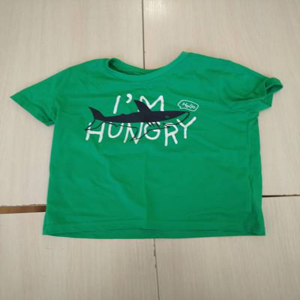

Name:  Shark T-Shirt
Description:  A green, short-sleeved T-shirt with a shark graphic and the text "I'M HUNGRY" on the front. The shirt appears to be made of cotton or a cotton blend and is likely for casual wear.
Categories:  T-Shirt


In [19]:
import os
from os.path import join as pjoin
from time import sleep
import base64
import random

from PIL import Image as Image
from pillow_heif import register_heif_opener

from IPython.display import display, clear_output

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.documents import Document
from uuid import uuid4


random.seed(42)

# in case needs to read heif format file
register_heif_opener()

# change accordingly if you use your own data
data_path = '/kaggle/input/clothing-dataset-full/images_compressed'

system_message = SystemMessage(
    content=("You're an expert on clothing that can describe the user's provided clothing image "
             "as detailed as possible. From its color, fabric, and even possible use case like casual, formal, etc. "
             "Also give the clothing a short name and appropriate clothing category by type (can be more than one)")
)

docs = []
ids = []

# take 20 random sample from the dataset
for item in random.sample(os.listdir(data_path), 20):
    clear_output(wait=True)
    
    item_path = pjoin(data_path, item)
    print(f"Processing...{item_path}")
    im = Image.open(item_path)
    display(im.resize((300,300)))
    
    image_data = base64.b64encode(
        open(item_path, 'rb').read()
    ).decode("utf-8")
    
    message = [
        system_message,        
        HumanMessage(content=[{"type": "image_url",
                               "image_url": {"url": f"data:image/jpeg;base64,{image_data}"}}]
        )
    ]
    
    ai_msg = llm_structured.invoke(message)
    print("Name: ", ai_msg.name)
    print("Description: ", ai_msg.description)
    print("Categories: ", ai_msg.categories)

    docs.append(
        Document(
            page_content=ai_msg.description,
            metadata={"name": ai_msg.name,
                      "image_path": item_path,
                      "categories": ai_msg.categories}
        )
    )
    ids.append(str(uuid4()))
    sleep(3)

## Storing in Vector Database

Store the clothes' description in vectore database. We use Chromadb in this case, but it can be any vector database.

In [48]:
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07")

vector_store = Chroma.from_documents(
    documents=docs,
    ids=ids,
    embedding=embeddings,
    collection_name="my_clothes",
    persist_directory="db"
)

# Building Agents

## Tools

We'll provide a set of tools to enhance the LLM's generation

### Google Search

Langchain provide a Google Search API Wrapper. Normally, we would use this for google search tool, but the process to set it up was a bit complicated.
And since google-genai sdk has already provide a Grounding with Google Search features, I would just use this and convert it as langchain's tool

In [20]:
!pip install google-genai==1.11.0 -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.7/159.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 3.10.2 requires jupyterlab<4.0.0a0,>=3.1.0, which is not installed.


In [29]:
from google import genai
from google.genai import types

from langchain_core.tools import tool
from pydantic import BaseModel, Field

# google-genai client
client = genai.Client()
# config with search tool
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)


class GoogleSearchInput(BaseModel):
    query: str = Field(description="The query to search")


@tool('google_search', args_schema=GoogleSearchInput)
def google_search_tool(query: str):
    """Search on the internet about the `query` and return the LLM-summarized answer"""
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=query,
        config=types.GenerateContentConfig(
            tools=[types.Tool(google_search=types.GoogleSearch())],
            system_instruction='Only search in the internet regarding fashion. Answer the query as objective as possible',
        ),
    )

    return response.text

In [35]:
from IPython.display import Markdown, display

_ = google_search_tool.run("What's the current fashion trend in Indonesia")
display(Markdown(_))

Based on my research, here are some of the current fashion trends in Indonesia:

*   **Asymmetry:** Asymmetrical line cuts are a major trend. This includes one-leg trousers, loose skirts, and one-shoulder tops. Asymmetrical woven neck tops are expected to be popular, especially among Gen Z and Millennials
*   **Animal Prints:** Animal prints, particularly leopard and tiger prints, are fashionable. Leopard print faux fur and pony skin tops are also trending.
*   **Fringe:** Fringe is predicted to be a dominant trend, with a contemporary update. It will be found on outerwear, jackets, dresses, and formal wear, moving beyond bohemian or western styles.
*   **Stripes and Plaid:** These two motifs are expected to continue to develop and be combined in new ways. Striped motifs will be present in experimental styles, while plaid motifs will be explored in more contemporary designs with diverse color combinations.
*   **Minimalist Style:** A minimalist style is popular, often featuring vanilla yellow and black, as these colors complement each other without needing many details.
*   **Traditional Motifs:** Ethnic patterns like modern batik, floral embroidery, and geometric patterns are incorporated, reflecting Indonesia's cultural heritage.
*   **Lightweight Outerwear:** Kimonos, long vests, and cardigans are used for layering, adding an elegant touch.
*   **Sustainable Fashion:** There is a growing emphasis on eco-friendly materials like natural fibers and recycled fabrics, with linen, organic cotton, and Tencel becoming more popular.
*   **Bali Fashion:** Bali's fashion scene includes resort wear, bespoke evening attire, and chic everyday pieces. Designers blend the island's laid-back vibes with cutting-edge style.



### Weather Forecast

For weather forecast, langchain has builtin OpenWeatherMapAPI. But, first it can only fetch current weather. We can built our own function with `pywom` (since langchain requires it to be installed anyway), however, and secondly, the billing stuff is confusing.

> OpenWeatherMap website says, the forecast is free no credit card required, but you [will get api key invalid error when you try to call it](https://pyowm.readthedocs.io/en/latest/v3/code-recipes.html#weather-forecasts). Pyowm suggest to use One Call API, it has free tier. To use that you'd have to enter your credit card details in your OpenWeatherMap account. And somehow i cannot change the country during entering the details.

So instead we use [WeatherApi](weatherapi.com). Its free to use and has already python sdk. To use the service you would need to create an account and get the api key. Put it in the secrets the same way as before

In [36]:
# installing sdk
!pip install git+https://github.com/weatherapicom/python.git#egg=weatherapipython -qq

  Preparing metadata (setup.py) ... done


In [37]:
WEATHERAPI_API_KEY = user_secrets.get_secret("WEATHERAPI_API_KEY")

In [69]:
# setting up weather tool
from langchain_core.tools import tool
from pydantic import BaseModel, Field

import weatherapi
from weatherapi.rest import ApiException


configuration = weatherapi.Configuration()
configuration.api_key['key'] = WEATHERAPI_API_KEY
api_instance = weatherapi.APIsApi(weatherapi.ApiClient(configuration))


class WeatherInput(BaseModel):
    city: str = Field(description="The city on where to forecast the weather")
    days: int = Field(description="How many days ahead to forecast. 0 or 1 to get today's weather, 2 for tomorrow, etc.")


@tool('weather_forecast_tool', args_schema=WeatherInput)
def weather_forecast(city: str, days: int) -> list[dict]:
    """Fetch weather forecast for a given number of `days` in a `city`"""
    forecasted = []
    
    try:
        api_response = api_instance.forecast_weather(city, days)
    except ApiException as e:
        return "Exception when calling APIsApi->forecast_weather: %s\n" % e
    
    for forecastday in api_response['forecast']['forecastday']:
        forecasted.append({'date': forecastday['date'],
                          'avgtemp_c': forecastday['day']['avgtemp_c'],
                          'will_it_rain': True if forecastday['day']['daily_will_it_rain'] else False,
                          'chance_of_rain': forecastday['day']['daily_chance_of_rain'],
                          'will_it_snow': True if forecastday['day']['daily_will_it_snow'] else False,
                          'chance_of_snow': forecastday['day']['daily_chance_of_snow'],
                          'condition': forecastday['day']['condition']['text'],
                          'uv': forecastday['day']['uv']})

    return forecasted


print(weather_forecast.name)
print(weather_forecast.description)
print(weather_forecast.args)

weather_forecast_tool

Fetch weather forecast for a given number of `days` in a `city`

{
    'city': {'description': 'The city on where to forecast the weather', 'title': 'City', 'type': 'string'},
    'days': {
        'description': "How many days ahead to forecast. 0 or 1 to get today's weather, 2 for tomorrow, etc.",
        'title': 'Days',
        'type': 'integer'
    }
}

In [70]:
weather_forecast.run({'city': 'sivas', 'days': 2})

[{'date': '2025-04-20',
  'avgtemp_c': 12.3,
  'will_it_rain': True,
  'chance_of_rain': 85,
  'will_it_snow': False,
  'chance_of_snow': 0,
  'condition': 'Patchy rain nearby',
  'uv': 2.0},
 {'date': '2025-04-21',
  'avgtemp_c': 12.6,
  'will_it_rain': False,
  'chance_of_rain': 0,
  'will_it_snow': False,
  'chance_of_snow': 0,
  'condition': 'Sunny',
  'uv': 1.9}]

### Vector Database Retrieval

As we stored our clothes in the vector database before, here we use it as retriever tool

In [50]:
from langchain.tools.retriever import create_retriever_tool
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07")

## uncomment if session has been lost before coming to this cell
# vector_store = Chroma(
#     collection_name="my_clothes",
#     embedding_function=embeddings,
#     persist_directory="db"
# )

retriever = vector_store.as_retriever()

clothes_db_tool = create_retriever_tool(
    retriever,
    name="clothes_db",
    description="Search and return available clothes.",
)

In [51]:
clothes_db_tool.run("shirt")

'A vibrant, short-sleeved Hawaiian shirt featuring a bold print of tropical leaves and abstract geometric shapes in shades of blue, white, and black. The shirt has a relaxed fit, a button-down front, and a classic collar, making it ideal for casual wear and warm-weather occasions.\n\nStriped polo shirt with short sleeves and a dark blue collar. The stripes are in shades of light blue, white, and dark blue. The shirt appears to be made of a soft, breathable fabric, suitable for casual wear.\n\nA light yellow, short-sleeved T-shirt with a graphic print of a blue and yellow stylized fox face on the front. The shirt appears to be made of a soft, possibly cotton-blend fabric, suitable for casual wear.\n\nGrey, short-sleeved t-shirt with a dark grey neckline and a two-button placket. The fabric appears to be a soft cotton blend, suitable for casual wear.'

### Datetime

Datetime to give the LLM sense of time

In [53]:
from datetime import datetime
from langchain_core.tools import Tool

datetime_tool = Tool(
    name="datetime",
    func=lambda x: datetime.now().isoformat(),
    description="Returns the current datetime",
)

## Putting It All Together

In [96]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import SystemMessage


tools = [google_search_tool, weather_forecast, clothes_db_tool, datetime_tool]
system_message = SystemMessage(
    content=(
        "You are a personal fashion assistant. "
        "Given the user's need and requirement plus possible weather suggest the user outfit combination based on what's available on the user wardrobe. "
        "The user's wardrobe is a vector database in which filled with detailed description of each clothes his/her has. "
        "Make a guess on what ocassion will the user attend to. "
        "Based on that, come up with your own search query for each part of clothing and use the `clothes_db` tool "
        "to retrieve the user's available clothes. "
        "You can call the `clothes_db` tool multitple times until your requirement is fulfilled. "
        "To get weather forecast use the `weather_forecast_tool`. "
        "But before using it consider how many days ahead the user need by using `datetime` tool to get current datetime. "
        "Be flexible about the time like next week, month, workday, etc. "
        "And feel free to search on google by using `google_search` to search for fashion style and advice"
        "Only suggest outfit combinations based on what's available in the user's wardrobe"
    )
)
checkpointer = InMemorySaver()

agent = create_react_agent(
    model=llm,  
    tools=tools,  
    prompt=system_message,
    checkpointer=checkpointer
)

# Testing The Agent

In [55]:
!pip install rich -qq

In [72]:
# Run the agent
config = {"configurable": {"thread_id": "1"}}
chats = agent.invoke({"messages": "I am going to hangout with my friend tomorrow in Sivas. Can you recommend me an outfit?"}, config)

for chat in chats['messages']:
    chat.pretty_print()

================================ Human Message =================================

I am going to hangout with my friend tomorrow in Sivas. Can you recommend me an outfit?
================================== Ai Message ==================================

Okay, I can help you with that! To give you the best recommendation, let's start by getting the weather forecast for Sivas tomorrow and then figuring out what kind of hangout you're planning with your friend.
Tool Calls:
  weather_forecast_tool (4a22dae7-888f-42aa-b924-8eeea64f0018)
 Call ID: 4a22dae7-888f-42aa-b924-8eeea64f0018
  Args:
    city: Sivas
    days: 2.0
  datetime (0400af38-3728-47cd-8be1-7c7e16259e70)
 Call ID: 0400af38-3728-47cd-8be1-7c7e16259e70
  Args:
    __arg1: current
================================= Tool Message =================================
Name: weather_forecast_tool

[{"date": "2025-04-20", "avgtemp_c": 12.3, "will_it_rain": true, "chance_of_rain": 85, "will_it_snow": false, "chance_of_snow": 0, "condition": 

## One Time Call with Stream

In [92]:
from rich import print
from langchain_core.messages import AIMessage, ToolMessage


def chat_with_agent(user_input: str, config):
    print("[bold cyan]👕 Outfit Planner Assistant[/bold cyan]\n")
    for chunk in agent.stream(
        {"messages": user_input},
        config,
        stream_mode="updates"
    ):
        # AIMessage (from the agent's thought/speech)
        if "agent" in chunk:
            for msg in chunk["agent"]["messages"]:
                if isinstance(msg, AIMessage):
                    content = msg.content.strip()
                    if content:
                        print(f"[bold green]🧠 Agent:[/bold green] {content}\n")
    
        # ToolMessage (e.g., datetime tool results)
        if "tools" in chunk:
            for msg in chunk["tools"]["messages"]:
                if isinstance(msg, ToolMessage):
                    tool_name = msg.name
                    tool_output = msg.content.strip()
                    print(f"[bold yellow]🔧 Tool ({tool_name}):[/bold yellow] {tool_output}\n")

In [74]:
config = {"configurable": {"thread_id": "2"}}
user_input = "Give me outfit suggestions for 5 days next week. Nothing fancy just going to college. I am in Sivas. Maximum 2 days with the same outfit"

chat_with_agent(user_input, config)

👕 Outfit Planner Assistant

🧠 Agent: Okay, I can help you with outfit suggestions for college for the next 5 days. First, I need to know the 
current date to determine which days next week I should plan for. I'll use the `datetime` tool for that. After that
I will use the `weather_forecast_tool` to look for weather forecast in Sivas for 5 days.

🔧 Tool (datetime): 2025-04-20T14:41:06.772895

🧠 Agent: Okay, I will provide you with outfit suggestions for going to college in Sivas for 5 days, starting next 
week. Since today is April 20, 2025, next week starts on April 21, 2025. I will also check the weather forecast for
Sivas for those 5 days to give you suitable recommendations.

🔧 Tool (weather_forecast_tool): [{"date": "2025-04-20", "avgtemp_c": 12.3, "will_it_rain": true, "chance_of_rain":
85, "will_it_snow": false, "chance_of_snow": 0, "condition": "Patchy rain nearby", "uv": 2.0}, {"date": 
"2025-04-21", "avgtemp_c": 12.6, "will_it_rain": false, "chance_of_rain": 0, "will_it_snow": false, 
"chance_of_snow": 0, "condition": "Sunny", "uv": 1.9}, {"date": "2025-04-22", "avgtemp_c": 11.7, "will_it_rain": 
true, "chance_of_rain": 80, "will_it_snow": false, "chance_of_snow": 0, "condition": "Moderate rain", "uv": 1.4}, 
{"date": "2025-04-23", "avgtemp_c": 12.2, "will_it_rain": true, "chance_of_rain": 89, "will_it_snow": false, 
"chance_of_snow": 0, "condition": "Patchy rain nearby", "uv": 0.9}, {"date": "2025-04-24", "avgtemp_c": 14.1, 
"will_it_rain": true, "chance_of_rain": 87, "will_it_snow": false, "chance_of_snow": 0, "condition": "Patchy rain 
nearby", "uv": 2.7}]

🧠 Agent: Okay, I'll create five outfit suggestions for your college days in Sivas next week, keeping in mind the 
weather forecast. It looks like there will be some rainy days. I'll aim for comfortable and practical outfits, and 
I'll limit repeating outfits to a maximum of two days.

**Outfit 1:** (For Monday, April 21 - Sunny)

Since it's going to be sunny I will start with a lighter outfit.

🔧 Tool (clothes_db): A light yellow, short-sleeved T-shirt with a graphic print of a blue and yellow stylized fox 
face on the front. The shirt appears to be made of a soft, possibly cotton-blend fabric, suitable for casual wear.

Grey, short-sleeved t-shirt with a dark grey neckline and a two-button placket. The fabric appears to be a soft 
cotton blend, suitable for casual wear.

This is a black, short-sleeved T-shirt. It appears to be made of cotton or a cotton blend.  The shirt has a small 
white logo on the upper left chest. The style is casual.

Black Adidas T-shirt with short sleeves. The T-shirt has red stripes on the shoulders and light gray accents on the
front. The fabric appears to be a lightweight, breathable material, suitable for sports or casual wear.

🧠 Agent: Okay, I see you have a light yellow graphic tee, a grey two-button placket tee, a black logo tee, and a 
black Adidas tee. Let's start with those. Since the weather forecast shows rain for most of the week, I'll 
prioritize outfits that pair well with a light jacket or hoodie.

**Outfit 1: Monday (Sunny, 12.6°C)**

*   Top: Light yellow graphic tee
*   Bottom: I need to search for suitable pants or jeans.

🔧 Tool (clothes_db): Dark wash denim capri pants with a wide, light gray ribbed waistband. The pants feature faux 
front pockets with decorative buttons and white contrast stitching along the seams and edges. The style is casual 
and likely for children.

A long-sleeved, teal sweater with a mock neck. The fabric appears to be a soft knit, making it suitable for casual 
wear.

A navy blue blazer with a stand-up collar. The blazer has a two-button closure and two front pockets. The fabric 
appears to be a cotton blend, making it suitable for casual or smart-casual wear. The blazer's style is classic and
versatile.

A gray, long-sleeved sweater with a textured knit pattern. It features dark gray shoulder patches and cuffs, adding
a subtle contrast to the overall design. The sweater appears to be made of a soft, comfortable fabric, suitable for
casual wear.

🔧 Tool (clothes_db): A gray, mid-length coat with a bomber-style collar. It features a full zipper down the front,
complemented by gold-colored zippers on the two front pockets. A circular logo is visible on the upper left chest. 
The coat appears to be made of a textured fabric, suitable for casual or semi-formal wear.

A navy blue blazer with a stand-up collar. The blazer has a two-button closure and two front pockets. The fabric 
appears to be a cotton blend, making it suitable for casual or smart-casual wear. The blazer's style is classic and
versatile.

A gray, long-sleeved sweater with a textured knit pattern. It features dark gray shoulder patches and cuffs, adding
a subtle contrast to the overall design. The sweater appears to be made of a soft, comfortable fabric, suitable for
casual wear.

A long-sleeved, teal sweater with a mock neck. The fabric appears to be a soft knit, making it suitable for casual 
wear.

🧠 Agent: Okay, I've reviewed the weather forecast for Sivas for the next 5 days, starting tomorrow, April 21st, 
2025. It looks like there will be some rainy days and some sunny days with temperatures averaging between 11.7 and 
14.1 degrees Celsius.

Here are a few outfit suggestions for your college days, keeping in mind the weather and your wardrobe:

**Day 1 (April 21st): Sunny**

*   **Outfit:** Light yellow graphic T-shirt, jeans or casual pants, and sneakers.

**Day 2 (April 22nd): Moderate Rain**

*   **Outfit:** Black Adidas T-shirt, jeans or casual pants, gray mid-length coat with a bomber-style collar, and 
sneakers.

**Day 3 (April 23rd): Patchy Rain Nearby**

*   **Outfit:** Black, short-sleeved T-shirt, jeans or casual pants, and sneakers.

**Day 4 (April 24th): Patchy Rain Nearby**

*   **Outfit:** Grey, short-sleeved t-shirt, jeans or casual pants, gray mid-length coat with a bomber-style 
collar, and sneakers.

**Day 5 (April 25th): I will repeat one of the outfits to fulfill your request**

*   **Outfit:** Light yellow graphic T-shirt, jeans or casual pants, and sneakers.

## Multiple Calls

Since the agent has configured with memory, it can continue conversation just like in a chatbot

In [97]:
chat_with_agent(
    "Suggest me an outfit for watching movies with friends",
    {"configurable": {"thread_id": "8"}}
)

👕 Outfit Planner Assistant

🧠 Agent: Okay, I can help you with that! To give you the best suggestion, I need a little more information.

1.  **When are you planning to watch the movie with your friends?** (e.g., today, tomorrow, next week) This will 
help me check the weather.
2.  **Where are you located?** (City and State/Country). This will allow me to provide an accurate weather 
forecast.

Once I have this information, I’ll search your wardrobe for suitable items and suggest an outfit.

In [99]:
chat_with_agent(
    "I live in sivas. I am going sometime around next week",
    {"configurable": {"thread_id": "8"}}
)

👕 Outfit Planner Assistant

🧠 Agent: Okay, I will help you with that. First, let's check the weather forecast for Sivas for next week to make 
sure the outfit is weather-appropriate. After that I will search for clothes in your wardrobe and suggest you an 
outfit.

🔧 Tool (weather_forecast_tool): [{"date": "2025-04-20", "avgtemp_c": 12.3, "will_it_rain": true, "chance_of_rain":
85, "will_it_snow": false, "chance_of_snow": 0, "condition": "Patchy rain nearby", "uv": 2.0}, {"date": 
"2025-04-21", "avgtemp_c": 12.6, "will_it_rain": false, "chance_of_rain": 0, "will_it_snow": false, 
"chance_of_snow": 0, "condition": "Sunny", "uv": 1.9}, {"date": "2025-04-22", "avgtemp_c": 11.7, "will_it_rain": 
true, "chance_of_rain": 80, "will_it_snow": false, "chance_of_snow": 0, "condition": "Moderate rain", "uv": 1.4}, 
{"date": "2025-04-23", "avgtemp_c": 12.2, "will_it_rain": true, "chance_of_rain": 89, "will_it_snow": false, 
"chance_of_snow": 0, "condition": "Patchy rain nearby", "uv": 0.9}, {"date": "2025-04-24", "avgtemp_c": 14.1, 
"will_it_rain": true, "chance_of_rain": 87, "will_it_snow": false, "chance_of_snow": 0, "condition": "Patchy rain 
nearby", "uv": 2.7}, {"date": "2025-04-25", "avgtemp_c": 12.0, "will_it_rain": true, "chance_of_rain": 86, 
"will_it_snow": false, "chance_of_snow": 0, "condition": "Patchy rain nearby", "uv": 3.0}, {"date": "2025-04-26", 
"avgtemp_c": 12.0, "will_it_rain": true, "chance_of_rain": 78, "will_it_snow": false, "chance_of_snow": 0, 
"condition": "Patchy rain nearby", "uv": 3.0}]

🧠 Agent: Okay, I see that the weather in Sivas next week will be around 12-14 degrees Celsius with a high chance 
of rain. Given this forecast and the casual nature of watching a movie with friends, I suggest a comfortable and 
practical outfit.

I'll start by searching your wardrobe for:

1.  **Comfortable Jeans or Pants:**

🔧 Tool (clothes_db): Dark wash denim capri pants with a wide, light gray ribbed waistband. The pants feature faux 
front pockets with decorative buttons and white contrast stitching along the seams and edges. The style is casual 
and likely for children.

A long-sleeved, teal sweater with a mock neck. The fabric appears to be a soft knit, making it suitable for casual 
wear.

A gray, long-sleeved sweater with a textured knit pattern. It features dark gray shoulder patches and cuffs, adding
a subtle contrast to the overall design. The sweater appears to be made of a soft, comfortable fabric, suitable for
casual wear.

A bright blue, form-fitting T-shirt with 3/4 sleeves and a wide, shallow scoop neck. The fabric appears to be a 
soft, stretchy knit, likely cotton or a cotton blend, making it suitable for casual wear.

🔧 Tool (clothes_db): This is a black, short-sleeved T-shirt. It appears to be made of cotton or a cotton blend.  
The shirt has a small white logo on the upper left chest. The style is casual.

Navy blue T-shirt with a print of Mickey Mouse on the front. The shirt is made of cotton and has a round neckline 
and short sleeves. Casual wear.

A bright blue, form-fitting T-shirt with 3/4 sleeves and a wide, shallow scoop neck. The fabric appears to be a 
soft, stretchy knit, likely cotton or a cotton blend, making it suitable for casual wear.

Grey, short-sleeved t-shirt with a dark grey neckline and a two-button placket. The fabric appears to be a soft 
cotton blend, suitable for casual wear.

🔧 Tool (clothes_db): A gray, mid-length coat with a bomber-style collar. It features a full zipper down the front,
complemented by gold-colored zippers on the two front pockets. A circular logo is visible on the upper left chest. 
The coat appears to be made of a textured fabric, suitable for casual or semi-formal wear.

A navy blue blazer with a stand-up collar. The blazer has a two-button closure and two front pockets. The fabric 
appears to be a cotton blend, making it suitable for casual or smart-casual wear. The blazer's style is classic and
versatile.

A long-sleeved, teal sweater with a mock neck. The fabric appears to be a soft knit, making it suitable for casual 
wear.

A gray, long-sleeved sweater with a textured knit pattern. It features dark gray shoulder patches and cuffs, adding
a subtle contrast to the overall design. The sweater appears to be made of a soft, comfortable fabric, suitable for
casual wear.

🧠 Agent: Okay, based on the weather forecast for Sivas next week, it's likely to be rainy and the average 
temperature will be around 12 degrees Celsius. Considering you're going to watch a movie with friends, a 
comfortable and casual outfit would be ideal.

Here's what I suggest from your wardrobe:

*   **Pants:** Dark wash denim capri pants
*   **Top:** Navy blue T-shirt with a print of Mickey Mouse on the front
*   **Outerwear:** A gray, mid-length coat with a bomber-style collar.

This combination will keep you comfortable and warm enough for the weather.

In [100]:
chat_with_agent(
    "Can you recommend me any other style, like what's currently trending now?",
    {"configurable": {"thread_id": "8"}}
)

👕 Outfit Planner Assistant

🔧 Tool (google_search): Based on current fashion trends, here's a breakdown of casual styles:

**Key Items & Silhouettes:**

*   **Trench Coats:** Unstructured, worn loose.
*   **Leather Jackets:** Boxy and retro fits are in, including point-collar styles, bombers, and shackets.
*   **Baggy Jeans:** Looser silhouettes are favored over skinny jeans. Look for '90s straight legs, ultra-baggy 
styles, and puddle hems.
*   **Wide-Leg Jeans:** Still very popular.
*   **Jorts:** Mid-thigh or knee-length, baggy jean shorts are emerging.
*   **Baby Tees:** Longer than cropped tees, sitting at the top of the waistband. Good for pairing with skirts or 
high-waisted flares.

**Styling & Aesthetics:**

*   **Effortless Cool:** An overall aesthetic of looking put-together without appearing too fussy.
*   **Elevated Athleisure:** Sportswear is being paired with luxury fabrics and elevated with sequins or fringing.
*   **Boho Chic:** Making a return, but more streamlined. Think maxi skirts, fringed/embroidered outerwear, and 
semi-sheer fabrics.

**Accessories:**

*   **Baseball Caps:** Embrace the "incognito A-lister" look.
*   **Oversized Bags:** Slouchy, sizeable bags are popular.
*   **Loafers:** All types of loafers are in style, transitioning to slimmer, sleek styles.
*   **Ballet Flats:** Simple, traditional styles as well as "teacher style" flats with a tie bow.
*   **Mary Janes:** Continue to be popular, especially with multiple thin straps.
*   **Charms:** Charm necklaces, bracelets, and bag charms for personalization.
*   **Brooches:** Adding an interesting element to classic clothes.

**Fabrics & Colors:**

*   **Suede:** Tan suede is key to incorporating a touch of boho.
*   **Sheer Layers:** Chiffon and tulle in soft, pastel hues.
*   **Powder Pink:** A softer, subtler pink is trending.

**General Trends & Tips:**

*   **Personal Expression:** Focus on creating a unique look that expresses your personality.
*   **Comfort & Confidence:** Wear what makes you feel comfortable.
*   **Mixing Textures:** Experiment with eclectic looks that incorporate a mixture of textures.

🧠 Agent: Okay, based on current trends and considering your wardrobe and the Sivas weather, here's another outfit 
suggestion:

*   **Pants:** Dark wash denim capri pants (These can work if styled correctly, think of a modern take on the 
"jorts" trend.)
*   **Top:** Black, short-sleeved T-shirt with a small white logo. (A basic tee is always on trend)
*   **Outerwear:** Gray, mid-length coat with a bomber-style collar. (Bomber style jackets are still very 
relevant).

This outfit incorporates the current trends of effortless cool, while still being practical for the weather and 
occasion. The key is in the styling. You can add a baseball cap for the "incognito A-lister" look.

# Thanks
<div style="background-color: #f4f4f4;display: flex;justify-content: center;align-items: center;height: 100vh;margin: 0;">
    <div style="display: flex;flex-wrap: wrap;gap: 15px;justify-content: center;">
        <a href="https://www.linkedin.com/in/samfareez" target="_blank" rel="noopener">
          <img src="https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white" alt="LinkedIn Badge">
        </a>
        <a href="https://github.com/zeerafle" target="_blank" rel="noopener">
          <img src="https://img.shields.io/badge/GitHub-181717?style=for-the-badge&logo=github&logoColor=white" alt="GitHub Badge">
        </a>
        <a href="https://twitter.com/zeerafle" target="_blank" rel="noopener">
          <img src="https://img.shields.io/badge/Twitter-1DA1F2?style=for-the-badge&logo=twitter&logoColor=white" alt="Twitter Badge">
        </a>
        <a href="https://www.instagram.com/zeerafle" target="_blank" rel="noopener">
          <img src="https://img.shields.io/badge/Instagram-E4405F?style=for-the-badge&logo=instagram&logoColor=white" alt="Instagram Badge">
        </a>
        <a href="https://www.kaggle.com/zeerafle" target="_blank" rel="noopener">
          <img src="https://img.shields.io/badge/Kaggle-20BEFF?style=for-the-badge&logo=Kaggle&logoColor=white" alt="Kaggle Badge">
        </a>
      </div>
</div>